In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import time

# cells defined in earlier notebooks

In [2]:
def R_nonbinding_3eq(y,t):
    """
    system of ODEs from Zaytsev 2016, simplified using two mass balances
    with the following components:
    - a: inactive Aurora B kinase
    - A: active Aurora B kinase
    - AA: enzyme-substrate complex of inactive + active Aurora B kinase
    - Ph: phosphatase
    - PhA: enzyme-substrate complex of phosphatase + active Aurora B kinase
    - a0: total Aurora B kinase
    - p0: total phosphatase
    """
    # set variable space
    A, AA, Ph = y
    
    # mass balances
    PhA = p0 - Ph
    a = a0 - A - 2*AA - PhA
    
    # reaction equations
    dAdt = (kcis - kfa*A)*a + (kra+2*kca)*AA - kfp*A*Ph + krp*PhA
    dAAdt = kfa*A*a - (kra+kca)*AA
    dPhdt = -kfp*A*Ph + (krp + kcp)*PhA
    
    return dAdt, dAAdt, dPhdt

In [3]:
"""
parameters from Zaytsev 2016
"""

kcis = 7.29*10**-6    # 1/s        # rate constant for 'in cis' Aurora B activation

kfa  = 0.1            # 1/(uM*s)   # rate constant for AA complex formation
kca  = 2.7*10**-2     # 1/s        # rate constant for AA catalysis
Kma  = 51             # uM         # Michaelis constant for AA 'in trans' activation
kra  = kfa*Kma-kca    # 1/         # rate constant for AA complex dissociation

kfp  = 0.6            # 1/(uM*s)   # rate constant for PhA complex formation
kcp  = 2.4*10**-2     # 1/s        # rate constant for PhA catalysis
Kmp  = 1.95           # uM         # Michaelis constant for PhA 'in trans' activation
krp  = kfp*Kmp-kcp    # 1/s        # rate constant for PhA complex dissociation

In [4]:
def saddle_node_locator(ss_list):
    """
    find point where steady state (ss) jumps (hysteresis)
    where unsteady state manifold appears/disappears
    """
    for n,(i,j) in enumerate(zip(ss_list[:-1], ss_list[1:])):
        if abs(j-i) > 0.3:
            return n+1

# demonstration of diffusion

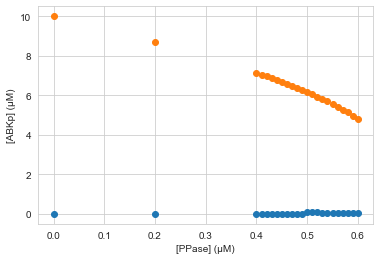

In [5]:
"""
algorithm to find high + low steady states 
for different phosphatase concentrations + 10 uM total kinase
uses zero for the low state in phosphatase concentrations with monostable high states
- to be used as initial active kinase concentrations for the spatial simulations below
"""
t = np.linspace(0,2000*60,2000*60)

a0 = 10

# build phosphatase concentration list
p0_range = [0,.2]
for n in np.arange(.4,.61,.01):
    p0_range.append(round(n,2))

# temporal evolution to find steady state concentrations with low initial kinase activity
lo_ss_nbns = []
for p0 in p0_range:
    y = odeint(R_nonbinding_3eq,[0,0,p0],t)
    A, aA, Ph = y[-1,:]
    
    # use zero initial active kinase for points with monostable high states
    if A > 1:
        lo_ss_nbns.append((str(p0),0,a0,0,p0,0))
    else:
        PhA = p0 - Ph
        a = a0-A-2*aA-PhA
        lo_ss_nbns.append((str(p0),A, a, aA, Ph, PhA))

# temporal evolution to find steady state concentrations with high initial kinase activity
hi_ss_nbns = []
for p0 in p0_range:
    y = odeint(R_nonbinding_3eq,[a0,0,p0],t)
    A, aA, Ph = y[-1,:]
    PhA = p0 - Ph
    a = a0-A-2*aA-PhA
    hi_ss_nbns.append((str(p0),A, a, aA, Ph, PhA))

# plot low/high steady state values to visualize
for p0, A, a, aA, Ph, PhA in lo_ss_nbns:
    plt.plot(float(p0),A,'C0o') # blue
for p0, A, a, aA, Ph, PhA in hi_ss_nbns:
    plt.plot(float(p0),A,'C1o') # orange

plt.xlabel('[PPase] (\u03BCM)')
plt.ylabel('[ABKp] (\u03BCM)');

In [6]:
"""
defines parameters for a demonstration of simple diffusion of kinase
evolving over a period of time with a defined diffusion coefficient, D
starts the simulation space at low kinase activity 
with a centrally localized perturbation of high kinase activity
"""

t_end = 1000*60      # s         # simulated time length
dt = 0.25            # s         # time discretization width, lower = finer resolution + greater simulation time
t_save = 60          # s         # how much time to let pass before saving

L = 18               # um        # domain length / distance between simulated boundaries
N = 300              # number    # space discretization points, L/N = space discretization width
x_span = np.linspace(-L/2,L/2,N)
perturb_width = 24   # number    # how many spatial intervals to start at the high active kinase state

D = 10**-5           # um^2/s    # diffusion coefficient

idx = 22                         # calls the low/high steady state values for 0.6 uM phosphatase
lo_ss = lo_ss_nbns[idx]
hi_ss = hi_ss_nbns[idx]
lostr, A0_lo, a0_lo, aA0_lo, Ph0_lo, PhA0_lo = lo_ss
histr, A0_hi, a0_hi, aA0_hi, Ph0_hi, PhA0_hi = hi_ss 

# active kinase starts at the low ss across the interval except for
# the perturbation in the center, which starts at high ss
A = np.ones(N)*A0_lo
A[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*A0_hi

In [7]:
def mesh_fourier(zmin,zmax,nz):
    """
    discrete approximation of the spatial derivative operator (Laplacian)
    uses spectral symmetry to simplify operations, forces periodic boundary conditions
    outperforms the standard central difference method by ~20x
    outperforms a vectorized central difference method by ~7.5x
    outperforms the built-in FFT module by ~12.5x
    outperforms a broadcasted Fourier mesh (np.einsum) by ~2x
    """
    dz = np.zeros((nz,nz))
    for i in range(nz):
        for j in range(nz):
            if i == j:
                dz[i,i] = 0
            else:
                dz[i,j] = np.pi*(-1)**((i-1)+(j-1))/(zmax-zmin)/np.tan(((i-1)-(j-1))*np.pi/(nz))
    return dz

In [8]:
"""
time evolution algorithm for the kinase diffusion demonstration
"""
# initialize saved data arrays
A_arr = np.zeros((N,round(t_end/t_save)+1))    # [space, time] matrix
t_vec = np.zeros(round(t_end/t_save)+1)

# initialize starting active kinase condition
A_arr[:,0] = A

# construct spatial derivative operator
dz = mesh_fourier(0,L,N)
dz2 = np.dot(dz,dz)

# start time + counters to track iteration progression / save points
t = 0
counter = 0
counter_save = 0

# loop + evolve system over succesive steps
for i in range(round(t_end/dt)+1):
    
    # step iteration progression counter forward
    counter += 1

    # evolve kinase profile according to diffusion
    A += dt*D*np.dot(dz2,A)     # dA/dt = D * dA^2/dz^2
    t += dt

    # save output every {t_save} minute, or {t_save/dt} iterations
    # reset iteration progression counter
    if counter == round(t_save/dt):
        counter = 0
        counter_save += 1

        A_arr[:,counter_save] = A
        t_vec[counter_save] = t

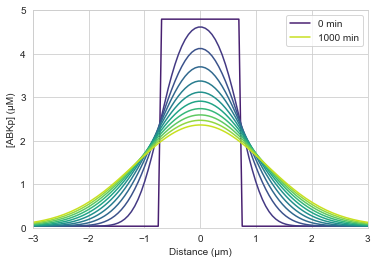

In [9]:
"""
Figure 10A
plots time evolution of the above algorithm, kinase diffusion from a perturbation
- simple diffusion creates spatial gradients that lose both amplitude + speed with time
"""

# calls every 100 time points from saved time vector
t_span = range(len(t_vec))[0::100]
# assigns color for every time point, on a gradient from blue to yellow
colors = sns.color_palette('viridis', n_colors=len(t_span))

# plots active kinase profile for each time point in t_span in the assigned color
for n,i in enumerate(t_span):
    # adds first + last time points to legend to show time:color relation
    if n == 0 or n == len(t_span)-1:
        plt.plot(x_span,A_arr[:,i], color=colors[n], label=f'{t_span[n]} min')
    else:
        plt.plot(x_span,A_arr[:,i], color=colors[n])

plt.legend()
plt.xlabel("Distance (\u03BCm)")
plt.ylabel("[ABKp] (\u03BCM)")
plt.ylim([0,5])
plt.xlim([-3,3]);

# bistability + diffusion : traveling fronts

In [11]:
def R_nonbinding_5eq(y,t):
    """
    system of ODEs from Zaytsev 2016, without simplifications
    """
    # unpack species profiles
    A, a, aA, Ph, PhA = y

    # calculate reaction equations
    dadt = -(kcis + kfa*A)*a + kra*aA + kcp*PhA
    dAdt = (kcis - kfa*A)*a + (kra + 2*kca)*aA - kfp*A*Ph + krp*PhA
    daAdt = kfa*A*a - (kra + kca)*aA 
    dPhdt = -kfp*A*Ph + (krp + kcp)*PhA
    dPhAdt = -dPhdt
    
    # output concentration changes
    return dAdt, dadt, daAdt, dPhdt, dPhAdt

In [10]:
def spatial_simulation_nonbind_ss_perturb(lo_ss,hi_ss,t_end,dt,t_save,L,N,perturb_width):
    """
    reaction-diffusion algorithm with a perturbed center width as initial conditions
    combines the above kinase-phosphatase reaction network + simple diffusion algorithm
    """
    # extract the information from the initial condition array function inputs
    lostr, A0_lo, a0_lo, aA0_lo, Ph0_lo, PhA0_lo = lo_ss
    histr, A0_hi, a0_hi, aA0_hi, Ph0_hi, PhA0_hi = hi_ss
    
    # initilize perturbed conditions for each reacting species
    A = np.ones(N)*A0_lo
    A[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*A0_hi
    a = np.ones(N)*a0_lo
    a[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*a0_hi
    aA = np.ones(N)*aA0_lo
    aA[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*aA0_hi
    Ph = np.ones(N)*Ph0_lo
    Ph[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*Ph0_hi
    PhA = np.ones(N)*PhA0_lo
    PhA[round(N/2-perturb_width/2):round(N/2+perturb_width/2)] = np.ones(perturb_width)*PhA0_hi
    
    # combine species profiles into a single variable
    y = A, a, aA, Ph, PhA
    
    A_arr = np.zeros((N,round(t_end/t_save)+1))
    t_vec = np.zeros(round(t_end/t_save)+1)
    
    A_arr[:,0] = A
    
    dz = mesh_fourier(0,L,N)
    dz2 = np.dot(dz,dz)
    
    counter = 0
    counter_save = 0
    t = 0
    
    for i in range(round(t_end/dt)+1):
        counter += 1
        
        # solve reaction equations
        dy = R_nonbinding_5eq(y,t)
        
        # evolve species profiles according to reaction + diffusion
        A += dt*( dy[0] + D*np.dot(dz2,A) )   # dA/dt = R(A,a,aA,Ph,PhA) + D * dA^2/dz^2
        a += dt*( dy[1] + D*np.dot(dz2,a) )
        aA += dt*( dy[2] + D*np.dot(dz2,aA) )
        Ph += dt*( dy[3] + D*np.dot(dz2,Ph) )
        PhA += dt*( dy[4] + D*np.dot(dz2,PhA) )
        
        y = A, a, aA, Ph, PhA
        
        t += dt
        
        if counter == round(t_save/dt):
            counter = 0
            counter_save += 1
            
            A_arr[:,counter_save] = A
            t_vec[counter_save] = t
        
        arrays = A_arr,t_vec
        y = A, a, aA, Ph, PhA
    
    # output saved data arrays + last concentration profile variable in case extension is desired
    return arrays, y

In [12]:
"""
demonstration of a traveling front, a bistable reaction-diffusion phenomenon
in the kinase-phosphatase system from an initial perturbed condition 
"""

t_end = 1000*60
dt = 0.25
t_save = 60

L = 6
N = 100
x_span = np.linspace(-L/2,L/2,N)
pw = 24

D = 10**-5

idx = 22
lo_ss = lo_ss_nbns[idx]
hi_ss = hi_ss_nbns[idx]

arrays, y = spatial_simulation_nonbind_ss_perturb(lo_ss,hi_ss,t_end,dt,t_save,L,N,pw)
A_arr, t_vec = arrays

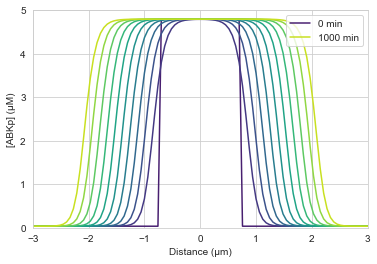

In [13]:
"""
Figure 10B/D
plots time evolution of spatial profiles of the above algorithm 
demonstrates traveling front behavior:
- creating spatial gradients that sustain both amplitude + speed with time
    - reliably propagates "information" as active kinase outwards (source signal reaches recipient)
    - travels with a linear speed, shown here as the equal temporal spacing between spatial profiles
"""

t_span = range(len(t_vec))[0::100]
colors = sns.color_palette('viridis', n_colors=len(t_span))
    
for n,i in enumerate(t_span):
    if n == 0 or n == len(t_span)-1:
        plt.plot(x_span,A_arr[:,i], color=colors[n], label=f'{t_span[n]} min')
    else:
        plt.plot(x_span,A_arr[:,i], color=colors[n])
        
plt.legend(loc='upper right')
plt.xlabel("Distance (\u03BCm)")
plt.ylabel("[ABKp] (\u03BCM)")
plt.ylim(0,5)
plt.xlim(-L/2,L/2);

In [15]:
"""
constructs bistability curve to visualize the traveling front mechanism
with fixed phosphatase concentration + independently varying total kinase concentration
"""
start = time.time()
## algorithm takes ~1 min

max_Atot = 15
P = 0.6
tspan = np.linspace(0,5000*60,10000)

Atot_range = np.arange(0,max_Atot,.05)
lo_list = []
hi_list = []
Atot_bistable_list = []
bistable_list = []

for Atot in Atot_range:

    # time evolutions starting with low + high active kinase levels
    lo_init = [0,Atot,0,P,0]
    y = odeint(R_nonbinding_5eq,lo_init,tspan)
    lo_ss = y[-1,0]
    lo_list.append(lo_ss)

    hi_init = [Atot,0,0,P,0]
    y = odeint(R_nonbinding_5eq,hi_init,tspan)
    hi_ss = y[-1,0]
    hi_list.append(hi_ss)

    # if steady states differ, system is bistable
    if not np.isclose(lo_ss, hi_ss, atol=.5):
        Atot_bistable_list.append(Atot)
        bistable_list.append((Atot, lo_ss, hi_ss))

# if bistability exists, time evolve at increasing kinase conc. until steady states diverge
unstablemanifold_list = []
for Atot, lo_ss, hi_ss in bistable_list:
    A0 = lo_ss
    y_sim = np.zeros((2,2))
    y_sim[-1,0] = -1
    while y_sim[-1,0] < np.average((A0,lo_ss)):
        A0 += .01
        A_init = [A0,Atot-A0,0,P,0]
        y_sim = odeint(R_nonbinding_5eq,A_init,tspan)
    unstablemanifold_list.append(A0)

# finds hysteresis points in low and high steady state curves
n_lo = saddle_node_locator(lo_list)
n_hi = saddle_node_locator(hi_list)

# build bistability curve - low branch / unstable manifold / high branch
saddle_x = [Atot_range[n_hi]] + Atot_bistable_list + [Atot_range[n_lo-1]]
saddle_y = [hi_list[n_hi]] + unstablemanifold_list + [lo_list[n_lo-1]]

end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

~ 1.2 min


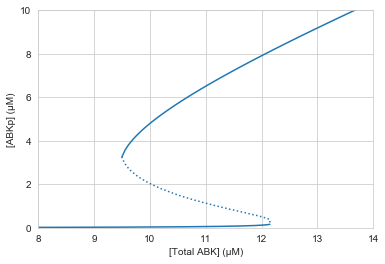

In [16]:
"""
Figure 10C
plots bistability curve, used along Figure 10D
- where the high + low steady states mix to a level above the unstable manifold,
- thus activating, forming a new edge of the high steady state front, progressively outwardly expanding
"""
plt.plot(Atot_range[:n_lo], lo_list[:n_lo], 'C0')
plt.plot(Atot_range[n_hi:], hi_list[n_hi:], 'C0')
plt.plot(saddle_x,saddle_y, 'C0:')
plt.xlabel('[Total ABK] (\u03BCM)')
plt.ylabel('[ABKp] (\u03BCM)')
plt.xlim(8,14)
plt.ylim(0,10);

In [17]:
"""
constructs bistability curve to visualize the traveling front mechanism
with fixed total kinase concentration + independently varying phosphatase concentration
"""
start = time.time()
## algorithm takes ~1 min

max_PPase = .8
Atot = 10
tspan = np.linspace(0,5000*60,10000)

PPase_range = np.arange(0,max_PPase,.005)
lo_list = []
hi_list = []
PPase_bistable_list = []
bistable_list = []

for P in PPase_range:

    # time evolutions starting with low + high active kinase levels
    lo_init = [0,Atot,0,P,0]
    y = odeint(R_nonbinding_5eq,lo_init,tspan)
    lo_ss = y[-1,0]
    lo_list.append(lo_ss)

    hi_init = [Atot,0,0,P,0]
    y = odeint(R_nonbinding_5eq,hi_init,tspan)
    hi_ss = y[-1,0]
    hi_list.append(hi_ss)

    # if steady states differ, system is bistable
    if not np.isclose(lo_ss, hi_ss, atol=.5):
        PPase_bistable_list.append(P)
        bistable_list.append((P, lo_ss, hi_ss))

unstablemanifold_list = []
for P, lo_ss, hi_ss in bistable_list:
    A0 = lo_ss
    y_sim = np.zeros((2,2))
    y_sim[-1,0] = -1
    while y_sim[-1,0] < np.average((A0,lo_ss)):
        A0 += .01
        A_init = [A0,Atot-A0,0,P,0]
        y_sim = odeint(R_nonbinding_5eq,A_init,tspan)
    unstablemanifold_list.append(A0)

n_lo = saddle_node_locator(lo_list)
n_hi = saddle_node_locator(hi_list)

saddle_x = [PPase_range[n_lo]] + PPase_bistable_list + [PPase_range[n_hi-1]]
saddle_y = [lo_list[n_lo]] + unstablemanifold_list + [hi_list[n_hi-1]]

end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

~ 0.8 min


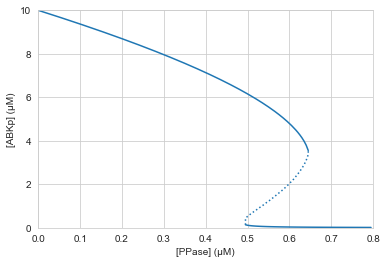

In [18]:
"""
Supplemental Figure 13
used to show the range of the bistable region for Figure 13B
"""
plt.plot(PPase_range[:n_hi], hi_list[:n_hi], 'C0')
plt.plot(PPase_range[n_lo:], lo_list[n_lo:], 'C0')
plt.plot(saddle_x,saddle_y, 'C0:')
plt.xlabel('[PPase] (\u03BCM)')
plt.ylabel('[ABKp] (\u03BCM)')
plt.xlim(0,.8)
plt.ylim(0,10);